In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import factorial2
from scipy.interpolate import splrep, splev
from scipy.special import comb
from numpy.polynomial.hermite import hermgauss
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv

In [55]:
def gaussian_moment(p, sigma):
    if p % 2 == 1:
        return 0
    else:
        return (sigma ** p) * math.prod(range(1, p, 2))  # (p - 1)!!

In [56]:
def alpha_convolution(alpha,k):
    result = 0
    for j in range(k + 1):
        if j < len(alpha) and (k - j) < len(alpha):
            result += alpha[j] * alpha[k - j]
    return result


In [57]:
def binom(k, i):
    return math.comb(k, i) if 0 <= i <= k else 0

Dans les modèles de volatilité rugueuse, le processus $X_t$ est souvent défini comme une approximation d'un noyau fractionnaire par un noyau exponentiel. On considère alors l'équation différentielle stochastique suivante :

$$
dX_t = -\frac{1/2 - H}{\varepsilon} X_t\, dt + \varepsilon^{H - \frac{1}{2}}\, dW_t
$$

où :

- $H \leq 0.5$ est le paramètre de Hurst qui contrôle la rugosité du processus.
- $\varepsilon > 0$ est un paramètre d'échelle qui permet d'approcher le noyau fractionnaire par un noyau exponentiel.
- $W_t$ est un mouvement brownien standard.

Ce processus est une version de l'Ornstein–Uhlenbeck, avec :

$$
\kappa = \frac{1/2 - H}{\varepsilon}, \quad \sigma = \varepsilon^{H - \frac{1}{2}}
$$

et peut être écrit de manière plus compacte comme :

$$
dX_t = -\kappa X_t\, dt + \sigma\, dW_t
$$
$$
X_t \sim \mathcal{N}\left( X_0 e^{-\kappa t},\ \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa t} \right) \right)
$$
La variance de $X_t$ est donnée par :

$$
\text{Var}(X_t) = \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa t} \right)
\newline
X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
\newline 
X_{t+h} = e^{-\kappa h}X_t+\sqrt{\frac{\sigma ^2}{2\kappa}(1-e^{-2\kappa h})}Z[k]

$$



In [58]:
def simulate_OU_X(T, n_steps, eps=1/52, H=0.1, N_sims=10000):
    """
    Simulates paths of the Ornstein-Uhlenbeck (OU) process and stores the trajectories and noise.

    Args:
        T (float): Total time duration for the simulation (e.g., 1 year).
        n_steps (int): Number of time steps in the simulation.
        eps (float, optional): Time scaling parameter (default is 1/52, assuming weekly steps).
        H (float, optional): Hurst parameter (default is 0.1).
        N_sims (int, optional): Number of simulation paths (default is 10000).

    Returns:
        Y_storage (ndarray): Array of shape (N_sims, n_steps) containing the standard normal random variables used as noise at each time step.
        trajectories (ndarray): Array of shape (N_sims, n_steps) containing the simulated Ornstein-Uhlenbeck process trajectories, scaled by the rough volatility term.
    """

    dt = T / n_steps
    X = np.zeros((N_sims, n_steps))
    X[:, 0] = np.random.normal(loc=1, scale=np.sqrt(2), size=N_sims)

    trajectories = np.zeros((N_sims, n_steps))
    Y_storage = np.zeros((N_sims, n_steps))
    
    kappa = (0.5 - H) / eps
    beta = np.sqrt(eps**(2 * H) / (1 - 2 * H))

    for i in range(1, n_steps):
        Z = np.random.randn(N_sims)  # N(0,1) noise
        dX = beta * (np.exp(kappa * i * dt / 2) - np.exp(kappa * (i - 1) * dt)) * Z
        X[:, i] = X[:, i - 1] + dX

        alpha = np.exp((0.5 - H) * (-i * dt) / eps)
        trajectories[:, i] = alpha * X[:, i]
        Y_storage[:, i] = Z

    return Y_storage, trajectories



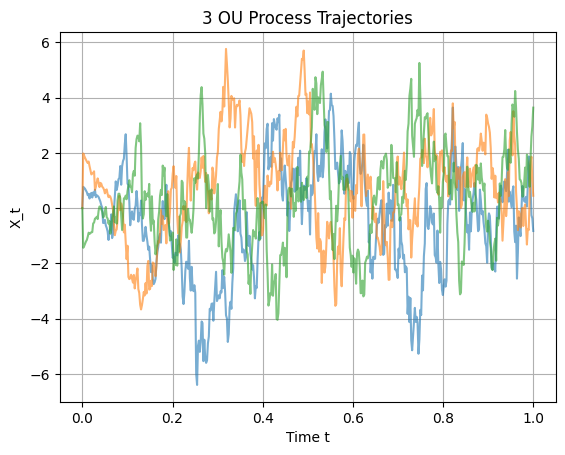

In [59]:
_, X = simulate_OU_X(T=1.0, n_steps=500, N_sims=10)
t = np.linspace(0, 1.0, 500)

for i in range(3):
    plt.plot(t, X[i], alpha=0.6)

plt.title("3 OU Process Trajectories")
plt.xlabel("Time t")

plt.ylabel("X_t")
plt.grid(True)
plt.show()


In [60]:
def gaussian_moment_GT(eps, H, T, u, power):
    """Compute E[(G_T^u)^power] where G_T^u ~ N(0, σ^2)"""
    delta = u - T
    if delta <= 0:
        return 0  # undefined if u < T
    if power % 2 == 1:
        return 0
    # Compute σ^2
    sigma2 = eps**(2 * H) * (1 - math.exp(-(1 - 2 * H) * eps**-1 * delta)) / (1 - 2 * H)
    sigma = math.sqrt(sigma2)
    # Compute even moment: σ^power * (power - 1)!!
    return gaussian_moment(power, sigma)


In numerical analysis, Gauss–Hermite quadrature is a form of Gaussian quadrature for approximating integrals of the form:
$$
\int_{-\infty}^{+\infty} e^{-x^2} f(x)\, dx
$$
This integral is approximated by a weighted sum:
$$
\int_{-\infty}^{+\infty} e^{-x^2} f(x)\, dx \approx \sum_{i=1}^n w_i f(x_i)
\newline
w_i = \frac{2^{n-1} n! \sqrt{\pi}}{n^2 \left[ H_{n-1}(x_i) \right]^2}
$$

In [61]:
def compute_VIX_squared(X_T, beta, Delta):
    """
    Compute VIX_T^2 = (100^2 / Delta) * sum_{i=0}^{10} β_i * X_T^i
    """
    vix2 = sum(beta[i] * (X_T ** i) for i in range(len(beta)))
    return (100**2 / Delta) * vix2

def compute_VIX(X_T, beta, Delta):
    """
    Compute VIX_T = sqrt(VIX_T^2)
    """
    vix_squared = compute_VIX_squared(X_T, beta, Delta)
    return math.sqrt(vix_squared)


In [62]:
# 5. Simulate log(S_t)
def simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory):
    """
    Simulate log-spot price paths log(S_t) under a rough volatility model
    using correlated Brownian increments.

    This function computes the log of asset prices for multiple Monte Carlo
    simulations, using precomputed volatility paths and standard Gaussian noise.

    Args:
        S0 (float): Initial spot price.
        sigma_t (ndarray): Array of shape (N_sims, n_steps) containing the volatility values σ_t for each path and time step.
        rho (float): Correlation coefficient between the asset and volatility Brownian motions.
        dt (float): Time step size.
        Y_trajectory (ndarray): Array of shape (N_sims, n_steps - 1) with i.i.d. standard normal samples representing Brownian increments.

    Returns:
        log_S (ndarray): Array of shape (N_sims, n_steps) containing simulated log-spot price paths.
    """
    N_sims, n_steps = sigma_t.shape
    log_S = np.zeros((N_sims, n_steps))
    log_S[:, 0] = np.log(S0)
    for i in range(1, n_steps):
        sigma_prev = sigma_t[:, i - 1]
        drift = -0.5 * (rho * sigma_prev)**2 * dt
        diffusion = rho * sigma_prev * np.sqrt(dt) * Y_trajectory[:, i - 1]
        log_S[:, i] = log_S[:, i-1] + drift + diffusion
    return log_S

3.0304259134891667
3.0304259134891667
[3.03042591 1.11164673]


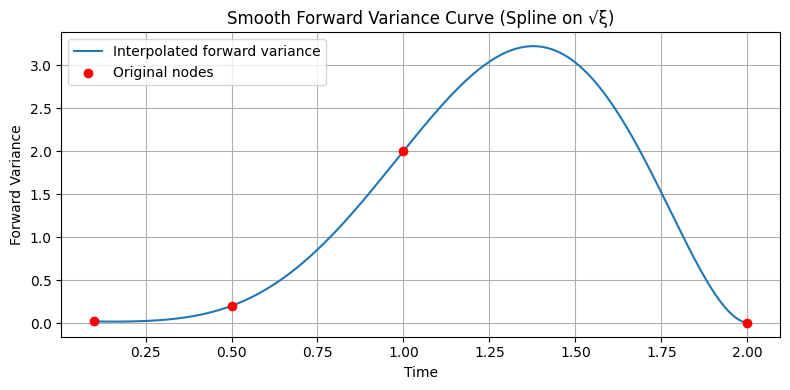

In [63]:
def make_fv_curve_interpolator(T_array_nodes, fv_nodes, spline_order=3):
    """
    Create a smooth interpolator for the forward variance curve using a spline on the square root 
    of the forward variance to preserve positivity.

    Args:
        T_array_nodes (array-like): Array of time points at which the forward variance is known.
        fv_nodes (array-like): Forward variance values corresponding to the time nodes.
        spline_order (int, optional): Order of the spline interpolation (default is 3 for cubic).

    Returns:
        fv (function): A function fv(t) that returns the interpolated forward variance at time t.
                       The input t can be a scalar or an array.
    """
    spline_sqrt = splrep(T_array_nodes, np.sqrt(fv_nodes), k=spline_order)

    def fv(t):
        t = np.asarray(t)
        sqrt_interp = splev(t, spline_sqrt, der=0)
        return np.square(sqrt_interp)

    return fv


# Example usage
T_array_nodes = np.array([0.1, 0.5, 1.0, 2.0])
fv_nodes = np.array([0.02, 0.2, 2, 0.002])
fv = make_fv_curve_interpolator(T_array_nodes, fv_nodes)

print(fv(1.5))  # scalar input → scalar output
print(fv(np.array(1.5)))  # scalar wrapped in array → still scalar
print(fv(np.array([1.5, 1.8])))  # vector input → array output

# Plotting
t_plot = np.linspace(min(T_array_nodes), max(T_array_nodes), 200)
fv_plot = fv(t_plot)

plt.figure(figsize=(8, 4))
plt.plot(t_plot, fv_plot, label="Interpolated forward variance")
plt.scatter(T_array_nodes, fv_nodes, color='red', zorder=5, label="Original nodes")
plt.title("Smooth Forward Variance Curve (Spline on √ξ)")
plt.xlabel("Time")
plt.ylabel("Forward Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result


$$X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
$$

In [65]:
import numpy as np
from scipy.special import factorial2  # faster and numerically stable

import numpy as np

def expected_fx_squared(a_k, eps=1/52, H=0.1, T=12, n_steps=1000):
    """
    Computes E[f(X)^2] where f(X) = a_0 + a_1 X + ... + a_d X^d,
    and X ~ N(0, var_X), using analytic Gaussian moments.

    Args:
        a_k: array of polynomial coefficients [a0, a1, ..., ad]
        eps: small epsilon value
        H: roughness parameter
        T: time horizon
        n_steps: number of time steps

    Returns:
        var_f: array of shape (n_steps,) with expected values E[f(X_t)^2]
    """
    # Coefficients of f(X)^2 = (sum a_k X^k)^2
    c_k = np.convolve(a_k, a_k)
    
    # Precompute double factorials for (k-1)!! for k in [0, len(c_k)-1] (even k)
    max_k = len(c_k) - 1
    # df_arr stores double factorials for n = k-1 (for even k)
    # df_arr[k+1] = (k-1)!! for k even
    df_arr = np.ones(max_k + 2)  # Covers indices 0 to max_k+1 (for n from -1 to max_k-1)
    # Iteratively compute double factorials for n >= 1
    for n in range(1, max_k):  # n from 1 to max_k-1
        df_arr[n + 2] = n * df_arr[n]  # n!! = n * (n-2)!!

    # Parameters for the Gaussian process X_t
    sigma_2 = eps**(2 * H - 1)  # Variance parameter
    kappa = (0.5 - H) / eps     # Mean reversion rate
    dt = T / n_steps            # Time step size
    t = np.arange(n_steps) * dt  # Time points [0, dt, 2*dt, ..., (n_steps-1)*dt]
    
    # Variance of X_t at each time point
    var_X = sigma_2 * (1 - np.exp(-2 * kappa * t)) / (2 * kappa) + 1e-8
    std = np.sqrt(var_X)  # Standard deviation of X_t

    # Compute E[f(X)^2] for each time step
    var_f = np.zeros(n_steps)
    # Sum over even powers (odd moments of Gaussian are zero)
    for k in range(0, len(c_k), 2):
        # For even k: E[X^k] = (k-1)!! * std^k
        var_f += c_k[k] * df_arr[k + 1] * (std**k)
        
    return var_f

$$X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
$$

In [66]:
def doublefactorial(n):
    if n <= 0:
        return 1
    else:
        return n * doublefactorial(n - 2)

In [67]:
def sigma(ksi_0, X, a_k, eps, H, T, n_steps, N_sims):
    """
    Compute the stochastic volatility process σ_t for a given simulation of the latent process X_t.

    The volatility is modeled as:
        σ_t = sqrt( ξ₀(t) * f(X_t)^2 / E[f(X_t)^2] )
    where f is a polynomial function defined by coefficients a_k.

    Args:
        ksi_0 (callable): Function ksi_0(t) giving the forward variance curve ξ₀(t), evaluated over [0, T].
        X (ndarray): Array of shape (N_sims, n_steps) containing simulated X_t paths.
        a_k (array-like): Coefficients [a₀, a₁, ..., a_d] of the polynomial f(x) = a₀ + a₁x + ... + a_d x^d.
        eps (float): Small parameter related to the roughness (not directly used here, included for completeness).
        H (float): Hurst parameter of the rough process (not directly used here, included for completeness).
        T (float): Total simulation time.
        n_steps (int): Number of time steps in the simulation.
        N_sims (int): Number of Monte Carlo simulation paths.

    Returns:
        ndarray: Array of shape (N_sims, n_steps) representing σ_t for each path and time step.
    """
    poly_vals = horner_vector(a_k, X)              # Evaluate f(X_t) using Horner's method
    f_X_squared = poly_vals ** 2                   # Compute f(X_t)^2
    expected_fx2 = np.mean(f_X_squared, axis=0) + 1e-10  # Expectation E[f(X_t)^2] over all paths (add epsilon for numerical stability)
    #expected_fx2 = expected_fx_squared(a_k, eps=eps, H=H, T=T, n_steps=n_steps)
    
    t_grid = np.linspace(0, T, n_steps)            # Time grid for ksi_0 evaluation
    ksi_vals = ksi_0(t_grid)                       # Forward variance values ksi_0(t)

    sigma_squared = f_X_squared * ksi_vals[None, :] / expected_fx2[None, :]  # Compute σ_t²
    return np.sqrt(sigma_squared)                  # Return σ_t


In [68]:
# 5. Simulate log(S_t)
def simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory):
    """
    Simulate log-price paths log(S_t) under a stochastic volatility model using precomputed volatility and Brownian increments.

    This function simulates multiple trajectories of the log-price process:
        log(S_{t_{i+1}}) = log(S_{t_i}) - 0.5 * (ρ * σ_{t_i})^2 * dt + ρ * σ_{t_i} * sqrt(dt) * Y_i
    where:
        - ρ is the correlation between the asset and volatility Brownian motions,
        - σ_{t_i} is the (precomputed) volatility at time t_i,
        - Y_i are standard normal i.i.d. variables (Brownian increments).

    Parameters
    ----------
    S0 : float
        Initial asset price.
    sigma_t : ndarray of shape (N_sims, n_steps)
        Matrix of volatility values σ_t for each simulation and each time step.
    rho : float
        Correlation coefficient between the Brownian motion of the asset and volatility (typically in [-1, 1]).
    dt : float
        Time step size (e.g., T / n_steps).
    Y_trajectory : ndarray of shape (N_sims, n_steps - 1)
        Precomputed standard normal random variables representing Brownian increments.

    Returns
    -------
    log_S : ndarray of shape (N_sims, n_steps)
        Simulated paths of log(S_t) for each simulation and each time step.
    """
    N_sims, n_steps = sigma_t.shape
    log_S = np.zeros((N_sims, n_steps))
    log_S[:, 0] = np.log(S0)
    for i in range(1, n_steps):
        sigma_prev = sigma_t[:, i - 1]
        drift = -0.5 * (rho * sigma_prev)**2 * dt
        diffusion = rho * sigma_prev * np.sqrt(dt) * Y_trajectory[:, i - 1]
        log_S[:, i] = log_S[:, i-1] + drift + diffusion
    return log_S


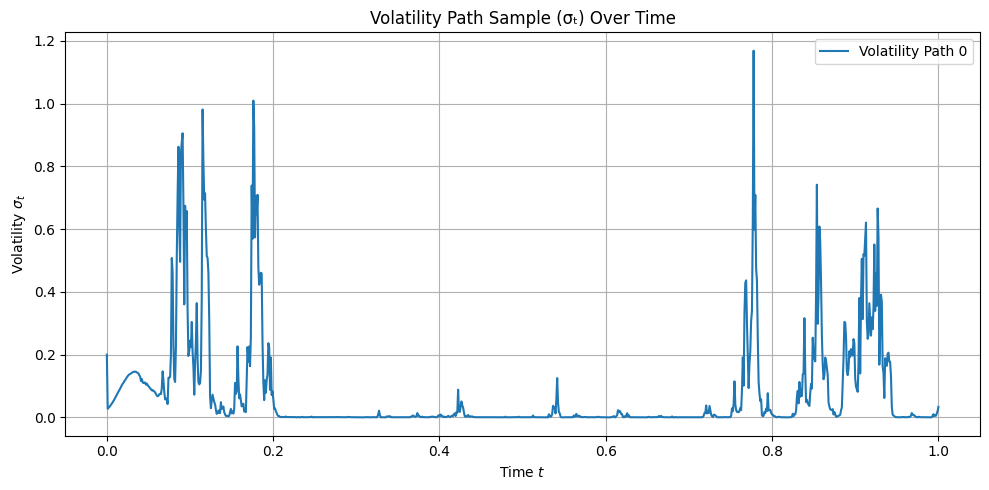

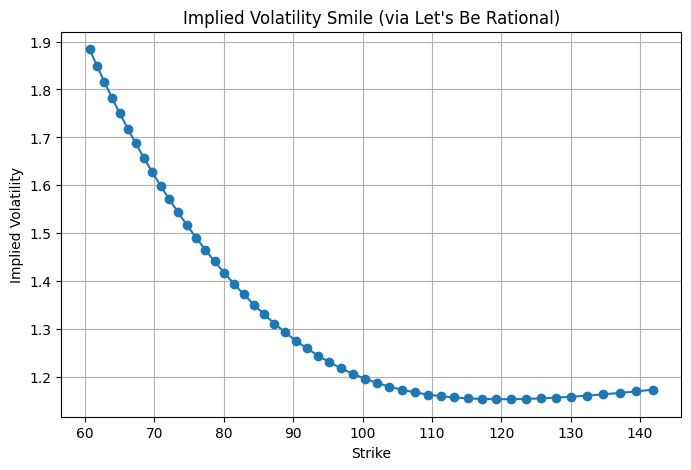

In [69]:

# 6. Vectorized implied volatility wrapper
def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

# ==== PARAMETERS ====
eps = 1/52
H = 0.1
a_k = [0.01, 0, 0.01, 0, 0.001, 0.5]
T = 1
n_steps = 1000
N_sims = 40000
S0 = 100
rho = 0.85
dt = T / n_steps

# Forward variance function
T_array_nodes = np.array([0, 0.5, 1.0, 1000])
fv_nodes = np.array([0.04, 0.04, 0.04, 0.4])  # 20% vol^2
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)

# ==== SIMULATIONS ====
Y_trajectory, X = simulate_OU_X(T, n_steps, eps, H, N_sims)
sigma_t = sigma(fv_func, X, a_k, eps, H, T, n_steps, N_sims)
# Select the first simulated path
sigma0 = sigma_t[0, :]
time_grid = np.linspace(0, T, n_steps)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_grid, sigma0, label='Volatility Path 0')

# Formatting
plt.title('Volatility Path Sample (σₜ) Over Time')
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\\sigma_t$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
log_S = simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory)
S_T = np.exp(log_S[:, -1])

# ==== OPTION PRICING ====
flag = 'c'
r = 0.0
lm = np.linspace(-0.5, 0.35, 50)
strike_array = S0 * np.exp(lm)

call_payoffs = np.maximum(S_T[:, None] - strike_array, 0)
call_prices = np.mean(call_payoffs, axis=0)

# ==== IMPLIED VOL ====
imp_vols = vec_find_vol_rat(call_prices, S0, strike_array, T, flag)

# Keep only valid entries
intrinsic_values = np.maximum(S0 - strike_array, 0)
valid = call_prices > intrinsic_values + 1e-4
strike_array_valid = strike_array[valid]
imp_vols_valid = imp_vols[valid]

# ==== PLOT ====
plt.figure(figsize=(8, 5))
plt.plot(strike_array_valid, imp_vols_valid, marker='o')
plt.title("Implied Volatility Smile (via Let's Be Rational)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


In [70]:
def compute_beta_vector_full(T, delta, eps, H, n_steps, ksi_0, a_k,X=X):
    """
    Compute the βᵢ vector for the VIX polynomial approximation under a quintic OU volatility model.

    This function calculates the coefficients βᵢ for expressing VIX_T² as a weighted polynomial of the form:
        VIX_T² ≈ ∑ βᵢ X_T^i
    where X_T follows a mean-reverting Gaussian process (Ornstein-Uhlenbeck), and f(X_t)² is approximated via its even moments.

    Parameters:
        T : float
            Time at which we evaluate VIX_T (e.g., 0.08333 for 1 month).
        delta : float
            VIX averaging window (e.g., 30/360).
        eps : float
            Small scaling parameter in the rough volatility model.
        H : float
            Hurst parameter (e.g., 0.1).
        n_steps : int
            Number of time steps between T and T + delta for integration.
        ksi_0 : callable
            Forward variance curve ξ₀(t) (squared instantaneous volatility).
        a_k : ndarray of shape (n,)
            Coefficients of the polynomial f(x) = a₀ + a₁x + ⋯ + a_d x^d.

    Returns:
        beta_integrated : ndarray of shape (2n - 1,)
            Coefficients βᵢ that define the polynomial expansion of VIX_T².
    """

    # Degree of polynomial f(x)
    n = len(a_k)

    # Integration interval [T, T+delta]
    T_delta = T + delta
    t_grid = np.linspace(T, T_delta, n_steps + 1)
    dt = (T_delta - T) / n_steps  # step size for integration

    # Constants from the rough volatility model
    kappa_tild = (0.5 - H) / eps
    eta_tild = eps ** (H - 0.5)

    # Step 1: Compute the Cauchy product of the polynomial with itself
    # This gives the coefficients of f(x)^2 = (∑ a_k x^k)^2
    # For example, (a0 + a1 x)^2 = a0^2 + 2 a0 a1 x + a1^2 x^2
    cauchy_product = np.convolve(a_k, a_k)  # shape (2n - 1,)

    # Step 2: Compute std[X_t] at each time t in the grid
    std_X_t = eta_tild * np.sqrt((1 / (2 * kappa_tild)) * (1 - np.exp(-2 * kappa_tild * (t_grid - T))))

    # Step 3: Compute expected value of f(X_t)^2 at each time t
    # f(X_t)^2 = ∑_{even k} c_k * σ_t^k * (k-1)!! for even k
    even_indices = np.arange(0, 2 * n - 1, 2)
    double_fac = np.array([factorial2(k - 1) for k in even_indices])  # (k - 1)!! for each even k

    # Raise std_X_t to even powers for each term
    std_powers = std_X_t[np.newaxis, :] ** even_indices[:, np.newaxis]  # shape (len(even_indices), len(t_grid))

    # Compute the expected value of f(X_t)^2
    # E[f(X_t)^2] = ∑ c_k * σ^k * (k-1)!!
    normal_var = np.sum(
        cauchy_product[even_indices][:, np.newaxis] * std_powers * double_fac[:, np.newaxis],
        axis=0
    )

    # Ensure numerical stability: avoid dividing by zero later
    normal_var = np.maximum(normal_var, 1e-12)
    
    # Step 4: Compute time-dependent βᵢ(t) for i = 0 to 2n-2
    beta_all = []
    for i in range(2 * n - 1):
        # We want all k such that k ≥ i
        k_array = np.arange(i, 2 * n - 1)
        kmi = k_array - i

        # Only include terms where (k - i - 1) is even, since odd moments vanish (Gaussian symmetry)
        valid = (kmi - 1) % 2 == 0
        if not np.any(valid):
            beta_all.append(np.zeros_like(std_X_t))
            continue

        k_valid = k_array[valid]
        kmi_valid = kmi[valid]

        # Compute terms of the form: σ^(k-i) * (k-i-1)!! * binomial(k, i) * c_k
        powers = std_X_t[np.newaxis, :] ** kmi_valid[:, np.newaxis]  # σ_t^(k-i)
        dfacs = factorial2(kmi_valid - 1)[:, np.newaxis]             # (k-i-1)!!
        binoms = comb(k_valid, i)[:, np.newaxis]                     # Binomial(k, i)
        coeffs = cauchy_product[k_valid][:, np.newaxis]              # c_k

        # Combine all factors
        beta_i_t = np.sum(powers * dfacs * binoms * coeffs, axis=0)  # Sum over valid k
        beta_all.append(beta_i_t)

    # Convert to array of shape (2n - 1, n_steps + 1)
    beta_all = np.array(beta_all)

    # Step 5: Multiply βᵢ(t) by forward variance ξ₀(t), normalize by E[f(X_t)^2]
    ksi_vals = ksi_0(t_grid)  # shape (n_steps + 1,)
    weighted_beta = beta_all * (ksi_vals / normal_var)[np.newaxis, :]  # shape (2n - 1, n_steps + 1)

    # Step 6: Integrate each βᵢ(t) over [T, T+delta] using trapezoidal rule
    beta_integrated = np.sum((weighted_beta[:, :-1] + weighted_beta[:, 1:]) / 2, axis=1) * dt

    return beta_integrated  # shape (2n - 1,)


In [71]:
def compute_vix_futures(beta, delta, eps, H, T, n=50):
    """
    Compute the expected VIX_T value (VIX futures price) using Gauss–Hermite quadrature.

    Parameters:
    -----------
    beta : ndarray of shape (d+1,)
    delta : float
    eps : float
    H : float
    T : float
    n : int
        Number of quadrature points.

    Returns:
    --------
    Ft : float
        Expected VIX_T.
    """
    exponent = (1 - 2 * H) * T / eps
    std_T = np.sqrt((eps**(2 * H) / (1 - 2 * H)) * (1 - np.exp(-exponent)))

    def h(x):
        x_scaled = x * std_T
        poly_val = np.polyval(beta[::-1], x_scaled)
        return 100 * np.sqrt(np.maximum(poly_val / delta, 1e-12))

    x, w = hermgauss(n)
    Ft = np.sum(w * h(x))
    return Ft / np.sqrt(np.pi)


In [72]:
def vix_call_price(K, beta, delta, eps, H, T, n=50):
    """
    Compute the price of a European call option on VIX_T using Gauss–Hermite quadrature.

    Parameters:
    -----------
    K : float
        Strike of the VIX option.
    beta : ndarray of shape (d+1,)
    delta : float
    eps : float
    H : float
    T : float
    n : int
        Number of quadrature points.

    Returns:
    --------
    price : float
        Call option price E[(VIX_T - K)^+]
    """
    exponent = (1 - 2 * H) * T / eps
    std_T = np.sqrt((eps**(2 * H) / (1 - 2 * H)) * (1 - np.exp(-exponent)))

    x, w = hermgauss(n)

    def h(x):
        x_scaled = x * std_T
        poly_val = np.polyval(beta[::-1], x_scaled)
        return 100 * np.sqrt(np.maximum(poly_val / delta, 1e-12))

    vix_vals = h(x)
    payoff_vals = np.maximum(vix_vals - K, 0)

    price = np.sum(w * payoff_vals)
    return price / np.sqrt(np.pi)

from numpy.polynomial.hermite import hermgauss

def vix_call_price(K, beta, delta, eps, H, T, n=50):
    """
    Compute VIX call option price using Gauss–Hermite quadrature.

    Parameters:
    - K: Strike price
    - beta: Coefficients of the polynomial f(X_T)
    - delta: VIX averaging window (e.g. 30/365)
    - eps, H: Rough volatility parameters
    - T: Time to maturity
    - n: Number of quadrature nodes

    Returns:
    - Option price E[(VIX_T - K)^+]
    """
    kappa_tild = (0.5 - H) / eps
    eta_tild = eps**(H - 0.5)
    std_X_T = eta_tild * np.sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * T)))

    # Gauss–Hermite nodes and weights
    x, w = hermgauss(n)
    X = std_X_T * x

    VIX_squared = np.polyval(beta[::-1], X) / delta
    #VIX_squared = np.maximum(VIX_squared, 1e-10)
    VIX = 100 * np.sqrt(VIX_squared)

    payoff = np.maximum(VIX - K, 0)
    return np.sum(w * payoff) / np.sqrt(np.pi)


/tmp/ipykernel_119059/579743506.py:65: RuntimeWarning: invalid value encountered in sqrt
  VIX = 100 * np.sqrt(VIX_squared)


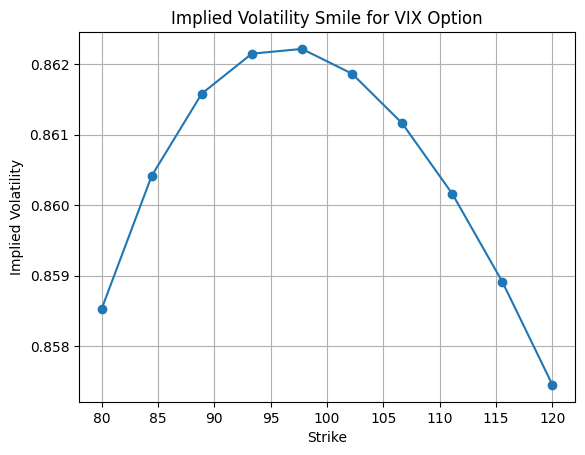

In [73]:
# Placeholder for your actual VIX forward value
T = 1/12  # maturity in years
r = 0.0   # risk-free rate
delta =30/360
eps = 1/52
H = 0.1
a_k = [0.001, 0, 0.01, 0, 0.001, 0.01]
T = 2
n_steps = 5000
N_sims = 1000
S0 = 100
rho = 0.85
dt = T / n_steps
delta = 30/365
kappa_tild = (0.5-H)/eps
eta_tild = eps**(H-0.5)
_, X = simulate_OU_X(T,n_steps)
X_T = X[:,-1]
T_delta = T + delta
tt = np.linspace(T, T_delta, n_steps+1)
std_X_T = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*T)))

#std_X_t = eta_tild*np.sqrt(1/(2*kappa_tild)*(1-np.exp(-2*kappa_tild*tt)))
beta = compute_beta_vector_full(T, delta, eps, H, n_steps, ksi_0=fv, a_k=a_k,X=X)
vix_T = compute_vix_futures(beta, delta, H=H, T=T,eps=eps)
K = 100
VIX_call_price = vix_call_price(K, beta, delta, eps, H, T, n=50)

# Define strikes
K_vec = np.linspace(80, 120, 10)

# Dummy function — replace with your own model
def vix_call_price(K, beta, delta, eps, H, T):
    # This dummy version just uses a decreasing exponential function for illustration
    return 10 * np.exp(-0.01 * (K - 80))

# Placeholder parameters for the pricing function (use your real ones)
beta = None
delta = None
eps = None
H = None

# Compute option prices
C_vec = [float(vix_call_price(K, beta, delta, eps, H, T)) for K in K_vec]

# Compute implied volatilities
IV_vec = []
for call_price, K in zip(C_vec, K_vec):
    try:
        iv = bs_iv(call_price, vix_T, K, T, flag='c', r=r)
    except Exception as e:
        print(f"Failed to compute IV for strike={K}: {e}")
        iv = np.nan
    IV_vec.append(iv)

IV_vec = np.array(IV_vec)

# Plot the smile
plt.plot(K_vec, IV_vec, marker='o')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile for VIX Option")
plt.grid(True)
plt.show()



In [86]:
import numpy as np
import scipy
from scipy import interpolate
from numpy import pi, sqrt, exp

def horner_vector(coeffs, n, x):
    """Efficient evaluation of polynomial using Horner’s method."""
    result = coeffs[0] * np.ones_like(x)
    for c in coeffs[1:]:
        result = result * x + c
    return result

def gauss_dens(mu, sigma, x):
    return 1 / (sqrt(2 * pi) * sigma) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def vec_find_vol_rat(prices, S0, strikes, T, r, flag):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception:
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

class VIX_One_QUINTIC:
    def __init__(self, eps, H, n_steps, delta, a_k, T=1/12, ub_vix=8.0, lb_vix=-8.0):
        self.eps = eps
        self.H = H
        self.n_steps = n_steps
        self.delta = delta
        self.a_k = np.array(a_k)
        self.T = T
        self.ub_vix = ub_vix
        self.lb_vix = lb_vix
        self.beta = None

    def compute_beta_vector_full(self, ksi_0):
        n = len(self.a_k)
        T_delta = self.T + self.delta
        dt = (T_delta - self.T) / self.n_steps
        tt = np.linspace(self.T, T_delta, self.n_steps + 1)
        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)

        std_Gs_T = eta_tild * np.sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * (tt - self.T))))
        std_X_t = eta_tild * np.sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * tt)))
        exp_det = np.exp(-kappa_tild * (tt - self.T))

        cauchy_product = np.convolve(self.a_k, self.a_k)
        even_indices = np.arange(0, 2 * n, 2)
        double_fac = scipy.special.factorial2(even_indices - 1)
        normal_var = np.sum(
            cauchy_product[even_indices][:, np.newaxis] *
            std_X_t[np.newaxis, :] ** even_indices[:, np.newaxis] *
            double_fac[:, np.newaxis],
            axis=0
        )

        ksi_vals = ksi_0(tt)
        beta_all = []
        for i in range(2 * n - 1):
            k_array = np.arange(i, 2 * n - 1)
            combs = scipy.special.comb(k_array, i).reshape(-1, 1)
            double_fac_i = np.array([
                scipy.special.factorial2(k - i - 1) if (k - i - 1) >= 0 else 0
                for k in k_array
            ]).reshape(-1, 1)
            odd_mask = ((k_array - i - 1) % 2).reshape(-1, 1)
            beta_temp = (
                std_Gs_T[np.newaxis, :] ** (k_array - i).reshape(-1, 1)
                * odd_mask * double_fac_i * combs
                * exp_det[np.newaxis, :] ** i
                * cauchy_product[k_array].reshape(-1, 1)
            )
            beta_all.append(np.sum(beta_temp, axis=0))
        beta_all = np.array(beta_all) * ksi_vals / normal_var
        self.beta = np.sum((beta_all[:, :-1] + beta_all[:, 1:]) / 2, axis=1) * dt

    def compute_vix_futures(self):
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        poly_val = horner_vector(self.beta[::-1], len(self.beta), std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)  # avoid negative sqrt
        vix_T = np.sqrt(poly_val / self.delta)

        density = gauss_dens(0.0, 1.0, y)
        return 100 * np.sum(density * vix_T * w)

    def vix_call_price(self, strike_perc_vix, compute_iv=True):
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        poly_val = horner_vector(self.beta[::-1], len(self.beta), std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)
        density = gauss_dens(0.0, 1.0, y)

        Ft = np.sum(density * vix_T * w)
        strikes = strike_perc_vix * Ft

        option_prices = np.sum(density * np.maximum(vix_T - strikes.reshape(-1, 1), 0.0) * w, axis=1)
        if compute_iv:
            imp_vol = vec_find_vol_rat(option_prices, Ft, strikes, self.T, 0.0, 'c')
            return Ft * 100, option_prices * 100, imp_vol
        else:
            return Ft * 100, option_prices * 100


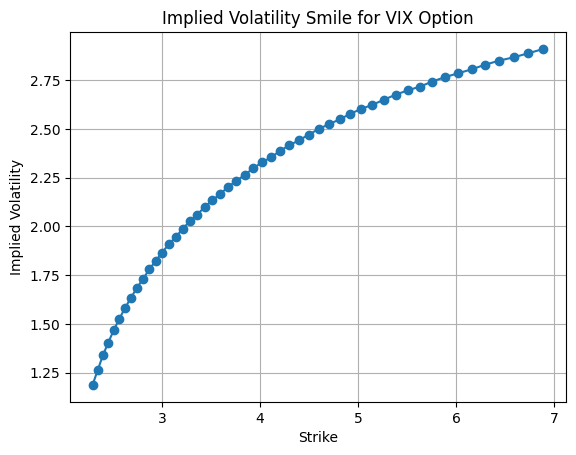

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv

# === Paramètres ===
eps = 1/52
H = 0.1
a_k = [0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1]
T = 9/365
n_steps = 400
N_sims = 10000
rho = -0.85
delta = 30/365
r = 0.0

# === Exemple de courbe de forward variance constante ===

# === Exemple de courbe de forward variance constante ===
T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

fv_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])



fv = interp1d(T_nodes, fv_nodes, kind='linear', fill_value="extrapolate")

# === Instanciation de la classe ===
model = VIX_One_QUINTIC(eps=eps, H=H, n_steps=n_steps, delta=delta,a_k= a_k,T=T)

# === Calcul du vecteur beta ===

model.compute_beta_vector_full(ksi_0=fv)

# === Calcul de VIX_T (forward VIX) ===
vix_T = model.compute_vix_futures()

# === Strikes à tester ===
lm_vix = np.linspace(-0.1,1,50)
K_vec = np.exp(lm_vix)
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
C_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    C_vec.append((Ft, price))  # stocke les deux pour IV

# === Calcul des volatilités implicites ===
IV_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    try:
        Ft = float(np.squeeze(Ft))
        price = float(np.squeeze(price))
        iv = bs_iv(price, Ft, Ft * K_i, T, r, 'c')
    except Exception as e:
        print(f"Failed to compute IV for strike={K_i}: {e}")
        iv = np.nan
    IV_vec.append(iv)

IV_vec = np.array(IV_vec)

# === Affichage de la smile ===
plt.plot(K_vec * vix_T, IV_vec, marker='o')  # x-axis = strike absolute
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile for VIX Option")
plt.grid(True)
plt.show()